# 📘 Employee Attrition - Data Cleansing

---

## 📄 Description  
This notebook performs a **Data Cleansing** which identifies and handles outliers in the dataset.  

## 👨‍💻 Author  
**Kfir Tayar** 

© Copyright 2025, Kfir Tayar. All rights reserved.  

## 🔹 Notebook Overview  
- Check for missing values  
- Plot Boxplot to detect outliers  
- Replace outliers values with NaN  
- Plot Heatmap of the outliers  
- Replace NaN's using MICE Imputer  
- Save the imputed file as a Pickle file

In [1]:
# Import Libraries & Modules
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Add the path to the utils directory
sys.path.append(os.path.abspath('../utils'))

from data_cleansing_utils import plot_missing_heatmap
from data_prep_utils import save_file_as_pickle

### Load Data Set

In [3]:
processed_df = pd.read_pickle("../Data/processed_employee_data_20250313.pkl")

In [4]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74498 entries, 0 to 74497
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Gender                    74498 non-null  category
 1   Years at Company          74498 non-null  int64   
 2   Job Role                  74498 non-null  category
 3   Monthly Income            74498 non-null  int64   
 4   Work-Life Balance         74498 non-null  category
 5   Job Satisfaction          74498 non-null  category
 6   Performance Rating        74498 non-null  category
 7   Number of Promotions      74498 non-null  category
 8   Overtime                  74498 non-null  category
 9   Distance from Home        74498 non-null  int64   
 10  Education Level           74498 non-null  category
 11  Marital Status            74498 non-null  category
 12  Number of Dependents      74498 non-null  category
 13  Job Level                 74498 non-null  cate

In [8]:
# Insure that there is 0 missing values
sum(processed_df.isna().sum())

0

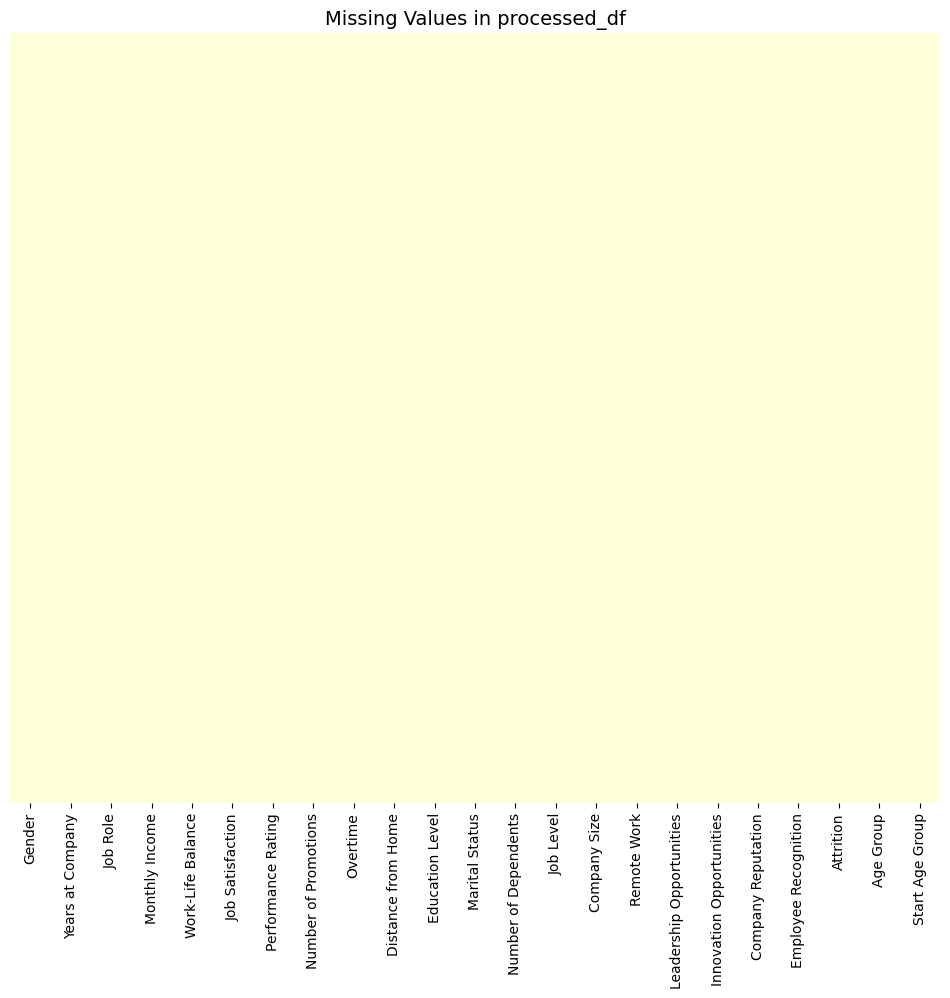

In [10]:
# Visualize missing values in processed_df
plot_missing_heatmap(processed_df, "Missing Values in processed_df")

### Create Boxplots for the continuous features

In [12]:
con_df = processed_df.select_dtypes(include=['number'])
con_df.head()

,Years at Company,Monthly Income,Distance from Home
0,19,5390,22
1,4,5534,21
2,10,8159,11
3,7,3989,27
4,41,4821,71


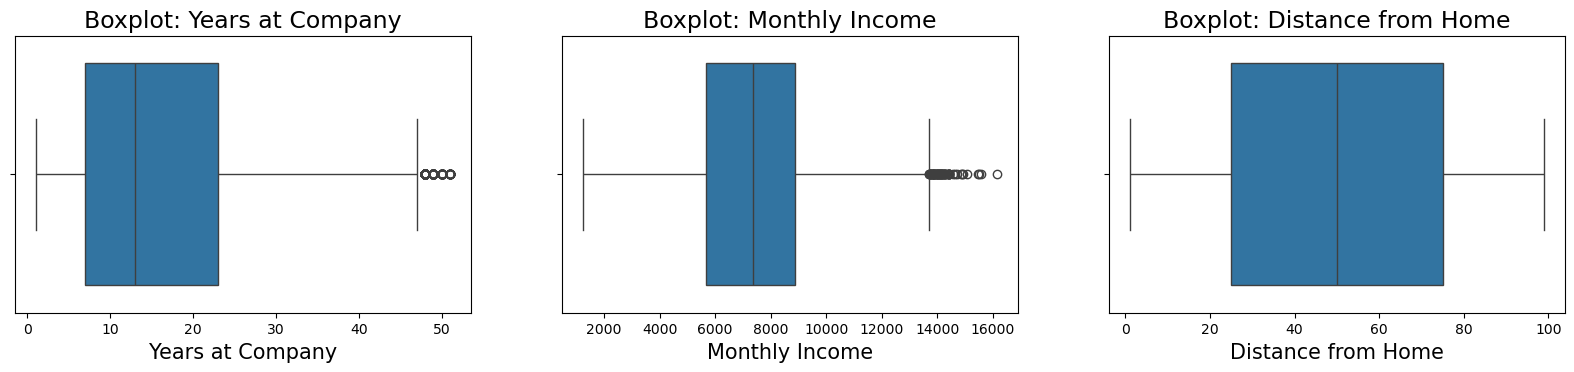

In [13]:
plt.figure(figsize=(20,200))

for i, col in enumerate(con_df.columns): 
    ax = plt.subplot(40, 3, i+1)
    sns.boxplot(data=con_df, x=col, ax=ax)
    plt.subplots_adjust(hspace = 0.4)
    plt.title('Boxplot: {}'.format(col), fontsize=17)
    plt.xlabel('{}'.format(col), fontsize=15)


- There is outlies in **'Years at Company'** & **'Monthly Income'** featues

### Turn the outlies into Missing Values

In [16]:
def replace_outliers_with_nan(df, threshold=1.5):
    df_clean = df.copy()
    
    for col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Replace outliers with NaN
        df_clean[col] = df_clean[col].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)

    return df_clean

In [17]:
# Example Usage
con_df_clean = replace_outliers_with_nan(con_df)
con_df_clean.head()

,Years at Company,Monthly Income,Distance from Home
0,19.0,5390.0,22
1,4.0,5534.0,21
2,10.0,8159.0,11
3,7.0,3989.0,27
4,41.0,4821.0,71


In [18]:
con_df_clean.isna().sum()

Years at Company      338
Monthly Income         65
Distance from Home      0
dtype: int64

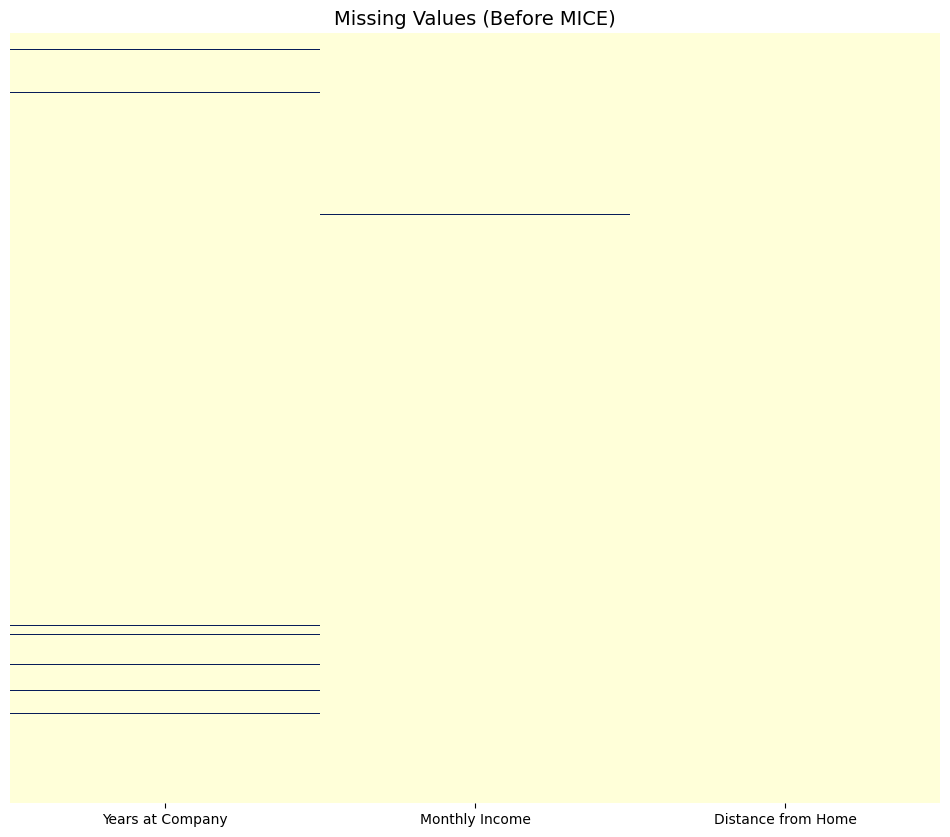

In [19]:
# Visualize missing values before imputation
plot_missing_heatmap(con_df_clean, "Missing Values (Before MICE)")

In [22]:
from sklearn.experimental import enable_iterative_imputer  # Enable experimental feature
from sklearn.impute import IterativeImputer

def fill_missing_mice(df, max_iter=10, random_state=42):
    """
    Fills NaN values using the MICE (Iterative Imputer) method.

    Parameters:
    - df: DataFrame with missing values.
    - max_iter: Number of imputation iterations.
    - random_state: Ensures reproducibility.

    Returns:
    - DataFrame with NaN values imputed.
    """
    imputer = IterativeImputer(max_iter=max_iter, random_state=random_state)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    return df_imputed

In [23]:
con_df_filled = fill_missing_mice(con_df_clean)

In [24]:
con_df_filled.isna().sum()

Years at Company      0
Monthly Income        0
Distance from Home    0
dtype: int64

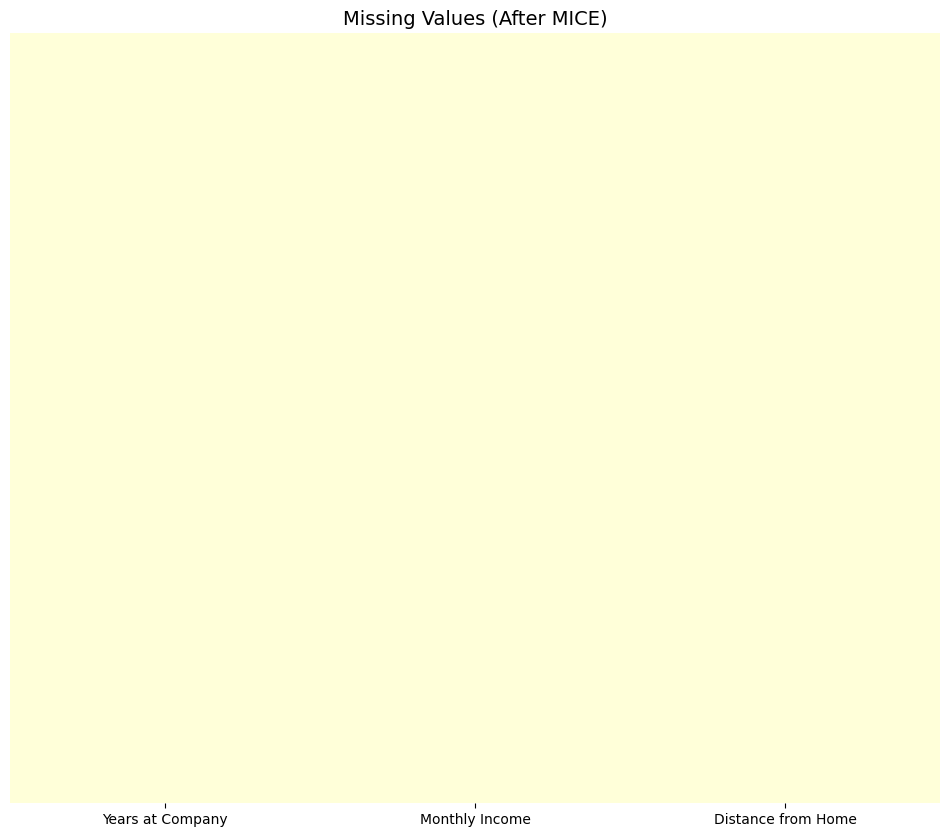

In [26]:
# Visualize missing values after imputation
plot_missing_heatmap(con_df_filled, "Missing Values (After MICE)")

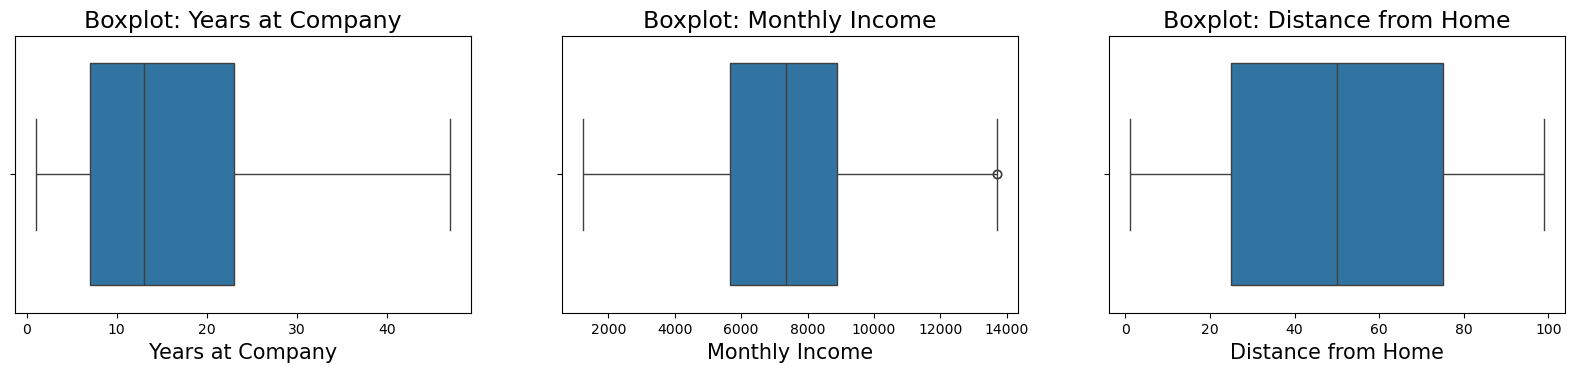

In [30]:
plt.figure(figsize=(20,200))

for i, col in enumerate(con_df_filled.columns): 
    ax = plt.subplot(40, 3, i+1)
    sns.boxplot(data=con_df_filled, x=col, ax=ax)
    plt.subplots_adjust(hspace = 0.4)
    plt.title('Boxplot: {}'.format(col), fontsize=17)
    plt.xlabel('{}'.format(col), fontsize=15)

### Create a df without outliers

In [33]:
imputed_df = processed_df.copy()
imputed_df['Years at Company'] = con_df_filled['Years at Company']
imputed_df['Monthly Income'] = con_df_filled['Monthly Income']
imputed_df['Distance from Home'] = con_df_filled['Distance from Home']

In [34]:
imputed_df.head()

,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,Distance from Home,...,Job Level,Company Size,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition,Age Group,Start Age Group
0,Male,19.0,Education,5390.0,Excellent,Medium,Average,2,No,22.0,...,Mid,Medium,No,No,No,Excellent,Medium,Stayed,30-40,8-18
1,Female,4.0,Media,5534.0,Poor,High,Low,3,No,21.0,...,Mid,Medium,No,No,No,Fair,Low,Stayed,>50,>40
2,Female,10.0,Healthcare,8159.0,Good,High,Low,0,No,11.0,...,Mid,Medium,No,No,No,Poor,Low,Stayed,23-30,8-18
3,Female,7.0,Education,3989.0,Good,High,High,1,No,27.0,...,Mid,Small,Yes,No,No,Good,Medium,Stayed,30-40,23-30
4,Male,41.0,Education,4821.0,Fair,Very High,Average,0,Yes,71.0,...,Senior,Medium,No,No,No,Fair,Medium,Stayed,>50,8-18


### Save df as a Pickle file

In [44]:
folder = "data"
file_name = "imputed_employee_data"

save_file_as_pickle(imputed_df, folder, file_name)

File saved as: ../data/imputed_employee_data_20250313.pkl
